In [127]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import bsr_array

warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)

## Data Extraction

In [2]:
base_path_to_dataset = "../../data/ml-1m/"

# read ratings
filename = "ratings.dat"
df_ratings = pd.read_csv(base_path_to_dataset+filename, header=None, sep="::")
df_ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]

# read users
filename = "users.dat"
df_users = pd.read_csv(base_path_to_dataset+filename, header=None, sep="::")
df_users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-Code"]

# read movies
filename = "movies.dat"
df_movies = pd.read_csv(base_path_to_dataset+filename, header=None, sep="::")
df_movies.columns = ["MovieID", "Title", "Genres"]

In [3]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_users.head()

,UserID,Gender,Age,Occupation,Zip-Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies_ratings = df_ratings.merge(df_movies, how="left", on="MovieID")

In [8]:
movies_ratings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [9]:
users_movies_rating = movies_ratings.merge(df_users, how="left", on="UserID")

In [10]:
users_movies_rating.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-Code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


## Data Extraction

---

Sum of ratings

In [11]:
films_summed_by_rating = df_ratings.groupby("MovieID").sum()


In [8]:
films_summed_by_rating.head(1200)

NameError: name 'films_summed_by_rating' is not defined

Average Rating

In [13]:
films_summed_by_rating_averaged = df_ratings.groupby("MovieID").sum() 

# Building User Filters

# Similarity measures 
- Cosine similarity

In [9]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
df_ratings['UserID'].unique()

array([   1,    2,    3, ..., 6038, 6039, 6040])

In [12]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
df_movies['Genres'].unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

In [14]:
r,c = df_movies[df_movies['Genres']=='(no genres listed)'].shape
print('The number of movies which do not have info about genres:',r)

The number of movies which do not have info about genres: 0


In [115]:
train_dataframe = df_movies.copy()

Text(0, 0.5, 'Counts')

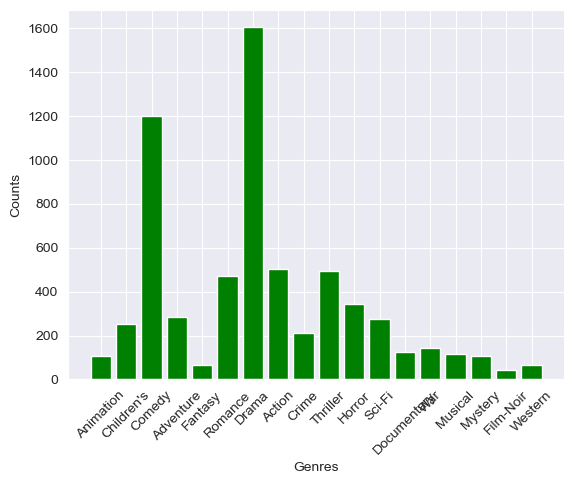

In [18]:
df_movies['Genres'] = df_movies['Genres'].str.replace('|',' ')
# count the number of occurences for each genre in the data set
counts = dict()
for i in df_movies.index:
    for g in df_movies.loc[i,'Genres'].split(' '):
        if g not in counts:
            counts[g] = 1
        else:
            counts[g] = counts[g] + 1
            
# create a bar chart
plt.bar(list(counts.keys()), counts.values(), color='g')
plt.xticks(rotation=45)
plt.xlabel('Genres')
plt.ylabel('Counts')

In [109]:
train_dataframe.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation Children's Comedy
1,2,Jumanji (1995),Adventure Children's Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
list(counts.keys())

['Animation',
 "Children's",
 'Comedy',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Sci-Fi',
 'Documentary',
 'War',
 'Musical',
 'Mystery',
 'Film-Noir',
 'Western']

In [32]:
train_dataframe[list(counts.keys())] = 0

In [110]:
# for genre in counts.keys():
train_dataframe['Genres'].apply(lambda x: x.split('|')) 

train_dataframe.apply()
    # if 

# train_dataframe['Genres'].str.split('|',expand=True)

TypeError: DataFrame.apply() missing 1 required positional argument: 'func'

In [103]:
train_dataframe.head()

,MovieID,Title,Genres,Film_Year
0,1,Toy Story (1995),Animation Child Comedy,1995
1,2,Jumanji (1995),Adventure Child Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy Romance,1995
3,4,Waiting to Exhale (1995),Comedy Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [87]:
len(train_dataframe)

3883

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer


/Users/yuriivoievidka/opt/anaconda3/envs/ucu-recsys/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [176]:
train_dataframe['Genres'] = train_dataframe['Genres'].str.replace('Sci-Fi','SciFi')
train_dataframe['Genres'] = train_dataframe['Genres'].str.replace('Film-Noir','Noir')
train_dataframe['Genres'] = train_dataframe['Genres'].str.replace('Children\'s','Child')
train_dataframe['Film_Year'] = train_dataframe['Title'].str.extract(r'(\d{4})')
train_dataframe['Film_Year'] = pd.to_numeric(train_dataframe['Film_Year'], errors='coerce')
# create an object for TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')
# apply the object to the genres column
tfidf_matrix = tfidf_vector.fit_transform(train_dataframe['Genres'])

In [177]:
train_dataframe.head()

,MovieID,Title,Genres,Film_Year
0,1,Toy Story (1995),Animation Child Comedy,1995
1,2,Jumanji (1995),Adventure Child Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy Romance,1995
3,4,Waiting to Exhale (1995),Comedy Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [164]:
# sparse_years = sparse.csr_matrix(np.array((train_dataframe['Film_Year'] - np.mean(train_dataframe['Film_Year']) / np.std(train_dataframe['Film_Year'])))).T

# tfidf_matrix = sparse.hstack([tfidf_matrix, sparse_years])
print("Data:", type(tfidf_matrix))

Data: <class 'scipy.sparse._coo.coo_matrix'>


In [165]:
tfidf_matrix.a = 0


In [166]:
tfidf_matrix.shape

(3883, 21)

In [167]:
print(tfidf_matrix)

  (0, 2)	0.7289010463348881
  (0, 3)	0.5917143302654576
  (0, 4)	0.34435071658181016
  (1, 3)	0.5163389780869351
  (1, 1)	0.49981350223804
  (1, 8)	0.6953995417662312
  (2, 4)	0.5731723830949155
  (2, 13)	0.8194348169667283
  (3, 4)	0.7556061240512079
  (3, 7)	0.655026247791881
  (4, 4)	1.0
  (5, 0)	0.5223554653131872
  (5, 5)	0.6710563133242528
  (5, 15)	0.5261446495072489
  (6, 4)	0.5731723830949155
  (6, 13)	0.8194348169667283
  (7, 3)	0.7185113022150282
  (7, 1)	0.6955152827862694
  (8, 0)	1.0
  (9, 1)	0.6420202354051012
  (9, 0)	0.5401673299903467
  (9, 15)	0.544085722052581
  (10, 4)	0.5133006700217896
  (10, 13)	0.7338393352398338
  (10, 7)	0.4449744399512637
  :	:
  (3858, 20)	1934.9618062716129
  (3859, 20)	1926.9618062716129
  (3860, 20)	1940.9618062716129
  (3861, 20)	1945.9618062716129
  (3862, 20)	1919.9618062716129
  (3863, 20)	1945.9618062716129
  (3864, 20)	1943.9618062716129
  (3865, 20)	1959.9618062716129
  (3866, 20)	1929.9618062716129
  (3867, 20)	1970.9618062716129

In [152]:
print(list(enumerate(tfidf_vector.get_feature_names_out())))


[(0, 'action'), (1, 'adventure'), (2, 'animation'), (3, 'child'), (4, 'comedy'), (5, 'crime'), (6, 'documentary'), (7, 'drama'), (8, 'fantasy'), (9, 'horror'), (10, 'musical'), (11, 'mystery'), (12, 'noir'), (13, 'romance'), (14, 'scifi'), (15, 'thriller'), (16, 'war'), (17, 'western')]


In [168]:
tfidf_vector = TfidfVectorizer(stop_words='english')


In [169]:
from sklearn.metrics.pairwise import linear_kernel

sim_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

In [170]:
print(sim_matrix)

[[11836371.20303887 11836370.50856404 11836370.40041119 ...
  11866164.82110158 11866164.82110158 11866164.82110158]
 [11836370.50856404 11836371.20303887 11836370.20303887 ...
  11866164.82110158 11866164.82110158 11866164.82110158]
 [11836370.40041119 11836370.20303887 11836371.20303887 ...
  11866164.82110158 11866164.82110158 11866164.82110158]
 ...
 [11866164.82110158 11866164.82110158 11866164.82110158 ...
  11896035.4391643  11896035.4391643  11896034.96301125]
 [11866164.82110158 11866164.82110158 11866164.82110158 ...
  11896035.4391643  11896035.4391643  11896034.96301125]
 [11866164.82110158 11866164.82110158 11866164.82110158 ...
  11896034.96301125 11896034.96301125 11896035.4391643 ]]


In [171]:
type(sim_matrix)

numpy.ndarray

In [172]:
sim_matrix.shape

(3883, 3883)

In [173]:
def similar_movies(movie_index, n_neighbours=10):
    film_similarities = sim_matrix[movie_index]
    print(f"Let's try to find similar movies to film: {train_dataframe.iloc[movie_index]['Title']}, {train_dataframe.iloc[movie_index]['Genres']}")
    inxex_of_similarties = film_similarities.argsort()[::-1][:n_neighbours]
    for i in inxex_of_similarties: 
        print(f"Movie with Id: {i}, Title: {train_dataframe.iloc[i]['Title']}, Genres: {train_dataframe.iloc[i]['Genres']} ")
    
    return inxex_of_similarties
    

In [175]:
similar_movies(20)

Let's try to find similar movies to film: Get Shorty (1995), Action Comedy Drama
Movie with Id: 2239, Title: Detroit 9000 (1973), Genres: Action Crime 
Movie with Id: 3775, Title: And God Created Woman (Et Dieu&#8230;Cr�a la Femme) (1956), Genres: Drama 
Movie with Id: 665, Title: Mystery Science Theater 3000: The Movie (1996), Genres: Comedy SciFi 
Movie with Id: 2242, Title: 2010 (1984), Genres: Mystery SciFi 
Movie with Id: 912, Title: 2001: A Space Odyssey (1968), Genres: Drama Mystery SciFi Thriller 
Movie with Id: 3828, Title: Bait (2000), Genres: Action Comedy 
Movie with Id: 3509, Title: Gladiator (2000), Genres: Action Drama 
Movie with Id: 3809, Title: Art of War, The (2000), Genres: Action 
Movie with Id: 3555, Title: Shanghai Noon (2000), Genres: Action 
Movie with Id: 3830, Title: Crime and Punishment in Suburbia (2000), Genres: Comedy Drama 


array([2239, 3775,  665, 2242,  912, 3828, 3509, 3809, 3555, 3830])